# Plot supplementary figure of MOAs that pass percent matching thresholds

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggrepel))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "supplementary", "moa_target_label_hits")
extensions <- c(".png", ".pdf")

In [3]:
results_dir <- file.path("../1.Data-exploration/Consensus/")

In [4]:
pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir)

print(dim(pm_cellpainting_list[["percent_matching"]]))
print(dim(pm_l1000_list[["percent_matching"]]))

print(dim(pm_cellpainting_list[["percent_matching_pvals"]]))
print(dim(pm_l1000_list[["percent_matching_pvals"]]))

[1] 1266    5
[1] 1266    5
[1] 1266    5
[1] 1266    5


In [5]:
p_val_alpha_thresh <- 0.05
plot_thresh <- -log10(p_val_alpha_thresh)

no_replicates_thresh <- 3

cell_painting_pm_df <- pm_cellpainting_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- pm_l1000_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

pm_df$dose <- factor(pm_df$dose, levels = dose_order)

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

# Output percent matching (MOA)
output_file <- file.path("results", "moa_scores.tsv")
readr::write_tsv(pm_df, output_file)

print(dim(pm_df))
head(pm_df)

[1] 1524    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,0.004444607,Cell Painting,0.513,FALSE,0.2898826
acetylcholine receptor agonist,8,0.04 uM,0.005142343,Cell Painting,0.576,FALSE,0.2395775
acetylcholine receptor antagonist,21,0.04 uM,0.019262183,Cell Painting,0.017,TRUE,1.7695511
adenosine receptor agonist,3,0.04 uM,0.009583710,Cell Painting,0.442,FALSE,0.3545777
adenosine receptor antagonist,4,0.04 uM,0.001703919,Cell Painting,0.612,FALSE,0.2132486
adrenergic receptor agonist,20,0.04 uM,0.005015938,Cell Painting,0.683,FALSE,0.1655793


In [6]:
moa_count_filter <- 2

moa_match_df <- pm_df %>% dplyr::filter(pass_thresh)

consistent_match_moa_df <- moa_match_df %>%
    dplyr::group_by(assay, moa) %>%
    dplyr::tally() %>%
    dplyr::filter(n >= !!moa_count_filter) %>%
    reshape2::dcast(moa ~ assay, value.var = "n") %>%
    tidyr::replace_na(
        list(
            `Cell Painting` = 0,
            L1000 = 0
        )
    ) %>%
    dplyr::mutate(x_axis_location = "Cell Painting")

consistent_match_moa_df$x_axis_location[consistent_match_moa_df$L1000 > 0] = "L1000"
consistent_match_moa_df$x_axis_location[(consistent_match_moa_df$L1000 > 0 & consistent_match_moa_df$`Cell Painting` > 0)] = "Both"

# Define the order to plot the text
cell_painting_order <- consistent_match_moa_df %>%
    dplyr::filter(x_axis_location == "Cell Painting") %>%
    dplyr::arrange(`Cell Painting`, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

l1000_order <- consistent_match_moa_df %>%
    dplyr::filter(x_axis_location == "L1000") %>%
    dplyr::arrange(L1000, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

both_order <- consistent_match_moa_df %>%
    dplyr::mutate(both_count = (`Cell Painting` + L1000) / 2) %>%
    dplyr::filter(x_axis_location == "Both") %>%
    dplyr::arrange(both_count, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

full_moa_plot_order <- dplyr::bind_rows(cell_painting_order, l1000_order, both_order)

plot_ready_moa_text_df <- consistent_match_moa_df %>% dplyr::left_join(full_moa_plot_order, by = "moa") %>%
    dplyr::mutate(replicate_count = `Cell Painting` + L1000)

plot_ready_moa_text_df$x_axis_location <- factor(plot_ready_moa_text_df$x_axis_location, levels = c("Cell Painting", "Both", "L1000"))

plot_ready_moa_text_df <- plot_ready_moa_text_df %>%
    dplyr::mutate(moa_with_replicate_count = paste0(moa, " (", replicate_count, ")"))

print(length(unique(plot_ready_moa_text_df$moa)))
head(plot_ready_moa_text_df)

[1] 40


,moa,Cell Painting,L1000,x_axis_location,y_axis_location,replicate_count,moa_with_replicate_count
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
1,acetylcholine receptor agonist,0,2,L1000,1,2,acetylcholine receptor agonist (2)
2,adenosine receptor antagonist,0,2,L1000,4,2,adenosine receptor antagonist (2)
3,akt inhibitor,4,0,Cell Painting,34,4,akt inhibitor (4)
4,alk tyrosine kinase receptor inhibitor,2,0,Cell Painting,1,2,alk tyrosine kinase receptor inhibitor (2)
5,androgen receptor agonist,6,3,Both,19,9,androgen receptor agonist (9)
6,angiotensin converting enzyme inhibitor,0,2,L1000,7,2,angiotensin converting enzyme inhibitor (2)


In [7]:
# Prep additional data for plotting
replicate_counts_df <- pm_df %>%
    tidyr::drop_na() %>%
    dplyr::group_by(moa, dose) %>%
    dplyr::mutate(avg_replicate_count = mean(no_of_replicates)) %>%
    dplyr::select(moa, dose, avg_replicate_count) %>%
    dplyr::ungroup() %>%
    dplyr::distinct()

cp_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "Cell Painting", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_cellpainting = pass_thresh)

l1000_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "L1000", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_l1000 = pass_thresh)

pass_thresh_both <- cp_pass_thresh %>%
    dplyr::full_join(l1000_pass_thresh, by = c("moa", "dose")) %>%
    tidyr::replace_na(list(pass_thresh_cellpainting = FALSE, pass_thresh_l1000 = FALSE)) %>%
    dplyr::mutate(pass_both = pass_thresh_cellpainting + pass_thresh_l1000) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE)) %>%
    dplyr::mutate(moa_color_passing = 0)

pass_thresh_both$moa_color_passing[pass_thresh_both$pass_both] <- "#DF74F0"
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_cellpainting & !pass_thresh_both$pass_both)] <- paste(assay_colors["Cell Painting"])
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_l1000 & !pass_thresh_both$pass_both)] <- assay_colors["L1000"]

plot_ready_pm_df <- pm_df %>%
    reshape2::dcast(moa + dose ~ assay, value.var = "matching_score") %>%
    tidyr::drop_na() %>%
    dplyr::left_join(replicate_counts_df, by = c("moa", "dose")) %>%
    dplyr::left_join(pass_thresh_both, by = c("moa", "dose")) %>%
    tidyr::replace_na(
        list(
            pass_thresh_cellpainting = FALSE,
            pass_thresh_l1000 = FALSE,
            pass_both = FALSE,
            moa_color_passing = "lightgrey"
        )
    )

In [8]:
moa_labels <- c("None", "L1000", "Cell Painting", "Both")

moa_colors <- unique(plot_ready_pm_df$moa_color_passing)
names(moa_colors) <- moa_labels
names(moa_labels) <- moa_labels

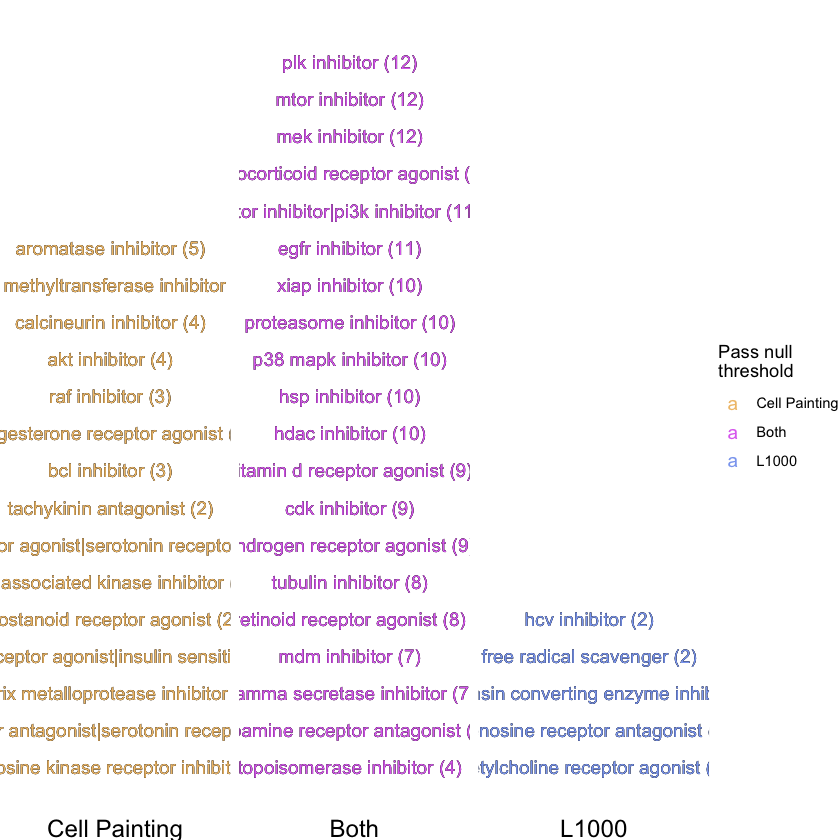

In [9]:
word_gg <- (
    ggplot(plot_ready_moa_text_df, aes(y = y_axis_location, x = 0))
    + geom_text(
        aes(
            label = moa_with_replicate_count,
        ),
        color = "black",
        size = 4
    )
    + geom_text(
        aes(
            label = moa_with_replicate_count,
        ),
        color = "black",
        size = 4
    )
    + geom_text(
        aes(
            label = moa_with_replicate_count,
            color = x_axis_location
        ),
        size = 4
    )
    + facet_wrap("~x_axis_location", strip.position = "bottom")
    + theme_void()
    + theme(strip.text = element_text(size = 14.5))
    + scale_color_manual(
        "Pass null\nthreshold",
        values = moa_colors
    )
    + xlim(-110, 120)
    + ylim(0, 60)
    + guides(color = guide_legend(order = 1))
)

word_gg

## Dose specific precision

In [10]:
# Load precision scores
precision_file <- file.path("..", "1.Data-exploration", "results", "moa_target_precision.tsv.gz")

precision_cols <- readr::cols(
  drug_impact = readr::col_character(),
  dose = readr::col_double(),
  avg_precision = readr::col_double(),
  impact_category = readr::col_character(),
  assay = readr::col_character()
)

# Load and process data for plotting
precision_df <- readr::read_tsv(precision_file, col_types = precision_cols) %>%
    reshape2::dcast(drug_impact+dose+impact_category~assay, value.var = "avg_precision") %>%
    dplyr::arrange(desc(L1000))

precision_df$dose <- dplyr::recode_factor(precision_df$dose, !!!dose_rename)
precision_df$dose <- factor(precision_df$dose, levels = dose_order)

impact_recode <- c("moa" = "MOA", "target" = "Gene target")
precision_df$impact_category <- dplyr::recode_factor(precision_df$impact_category, !!!impact_recode)
precision_df$impact_category <- factor(precision_df$impact_category, levels = impact_recode)

head(precision_df, 5)

,drug_impact,dose,impact_category,cell_painting,L1000
,<chr>,<fct>,<fct>,<dbl>,<dbl>
1,HSP90AA1,0.04 uM,Gene target,0.6666667,1
2,HSP90AA1,0.12 uM,Gene target,0.2500000,1
3,inosine monophosphate dehydrogenase inhibitor,10 uM,MOA,0.5833333,1
4,MAP3K1,10 uM,Gene target,0.1428571,1
5,proteasome inhibitor,3.33 uM,MOA,0.9093855,1


Warning message:
“Removed 18 rows containing missing values (geom_point).”


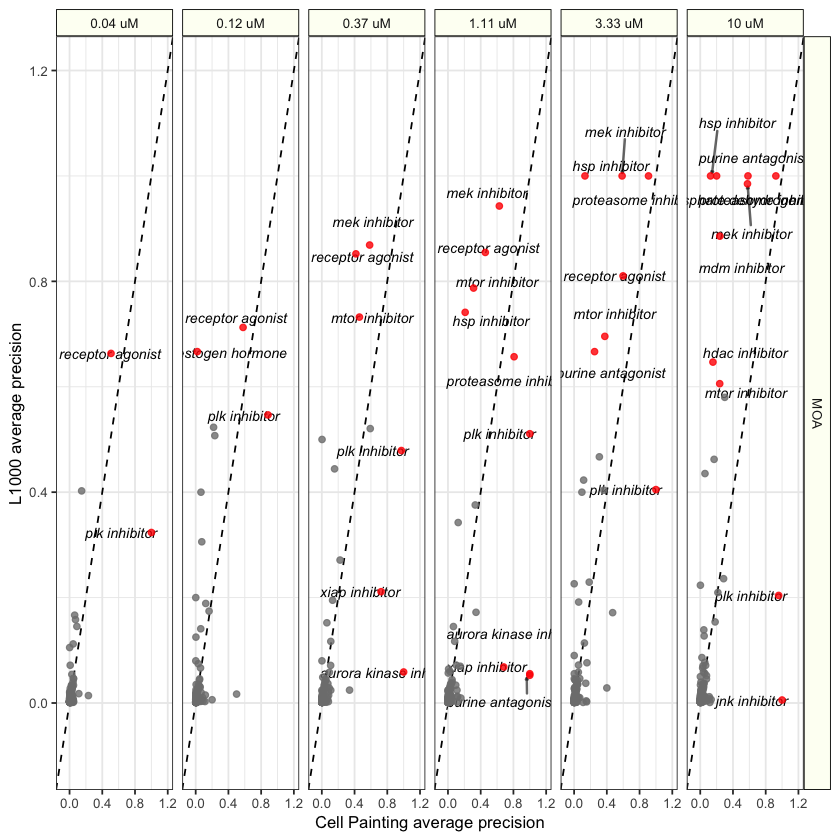

In [11]:
panel_d_df <- precision_df %>% dplyr::filter(impact_category == "MOA")

color_logic <- (
    panel_d_df$L1000 > 0.60 |
    panel_d_df$cell_painting > 0.6
    )

moa_gg <- (
    ggplot(panel_d_df, aes(x = cell_painting, y = L1000))
    + facet_grid("impact_category~dose")
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + xlab("Cell Painting average precision")
    + ylab("L1000 average precision")
    + ylim(-0.1, 1.2)
    + xlim(-0.1, 1.2)
    + geom_text_repel(
        data = subset(panel_d_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.7,
        segment.alpha = 0.6,
        size = 3,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.25,
        aes(
            x = cell_painting,
            y = L1000,
            label = drug_impact,
        )
    )
    + geom_point(color = ifelse(color_logic, "red", "grey50"), alpha = 0.8)
)

moa_gg

Warning message:
“Removed 228 rows containing missing values (geom_point).”


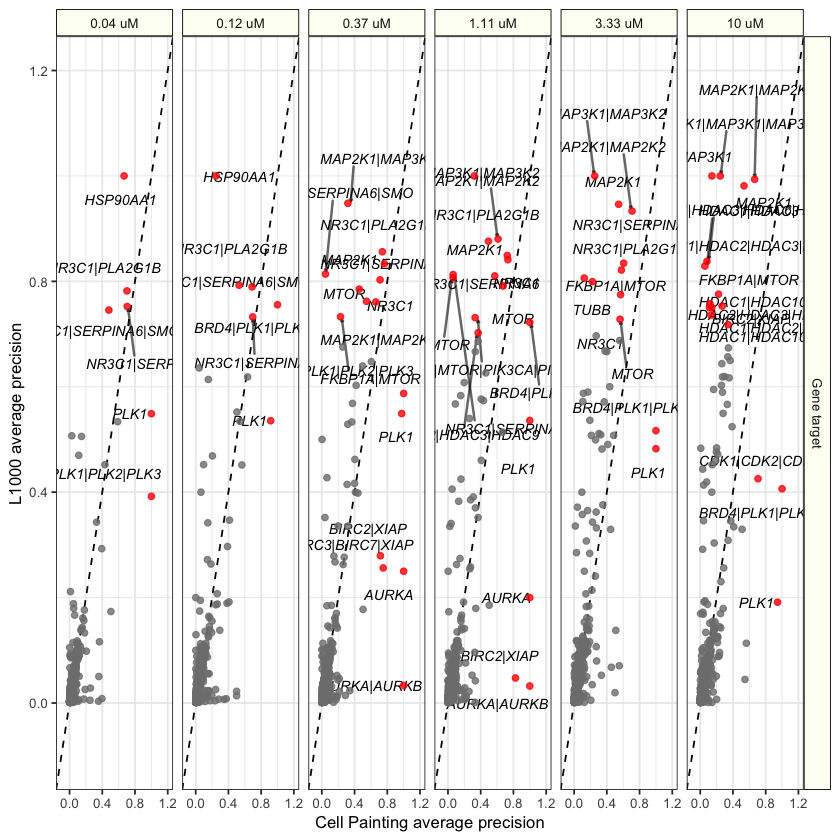

In [12]:
panel_e_df <- precision_df %>% dplyr::filter(impact_category == "Gene target")

color_logic <- (
    panel_e_df$L1000 > 0.70 |
    panel_e_df$cell_painting > 0.7
    )

gene_gg <- (
    ggplot(panel_e_df, aes(x = cell_painting, y = L1000))
    + facet_grid("impact_category~dose")
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + xlab("Cell Painting average precision")
    + ylab("L1000 average precision")
    + ylim(-0.1, 1.2)
    + xlim(-0.1, 1.2)
    + geom_text_repel(
        data = subset(panel_e_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.7,
        segment.alpha = 0.6,
        size = 3,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.25,
        aes(
            x = cell_painting,
            y = L1000,
            label = drug_impact,
        )
    )
    + geom_point(color = ifelse(color_logic, "red", "grey50"), alpha = 0.8)
)

gene_gg

Warning message:
“Removed 18 rows containing missing values (geom_point).”
Warning message:
“Removed 228 rows containing missing values (geom_point).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”
Warning message:
“Removed 228 rows containing missing values (geom_point).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”
Warning message:
“Removed 228 rows containing missing values (geom_point).”


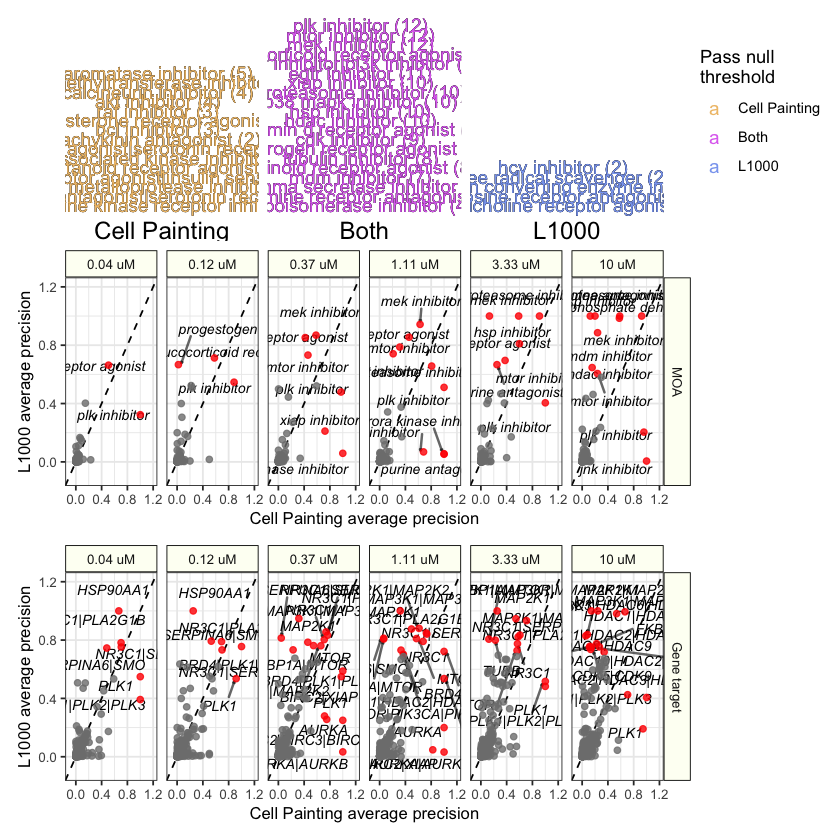

In [13]:
# Compile figure
sup_fig_gg <- (
    word_gg /
    moa_gg /
    gene_gg
)

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, sup_fig_gg, width = 18, height = 12, dpi = 500)
}

sup_fig_gg